In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sandi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
# Load your finance news data
df_all = pd.read_csv("data/all_financial_news.csv")  # Ensure this file is in your working directory


In [3]:
# Convert publishedAt to datetime (with UTC to avoid future timezone issues)
df_all['publishedAt'] = pd.to_datetime(df_all['publishedAt'], errors='coerce', utc=True)

# Drop rows with missing or invalid datetime
df_all.dropna(subset=['publishedAt'], inplace=True)

# Sort by date
df_all.sort_values(by='publishedAt', ascending=True, inplace=True)


In [4]:
# Initialize sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Apply sentiment scoring on description column
df_all['sentiment_score'] = df_all['description'].astype(str).apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Extract only the date part (drop time)
df_all['date'] = df_all['publishedAt'].dt.date


In [5]:
# Group by date to get mean sentiment per day
daily_sentiment = df_all.groupby('date')['sentiment_score'].mean().reset_index()


In [6]:
# Step 6: Add risk alert column
risk_threshold = -0.2  # Set your threshold
daily_sentiment['risk_alert'] = daily_sentiment['sentiment_score'] < risk_threshold


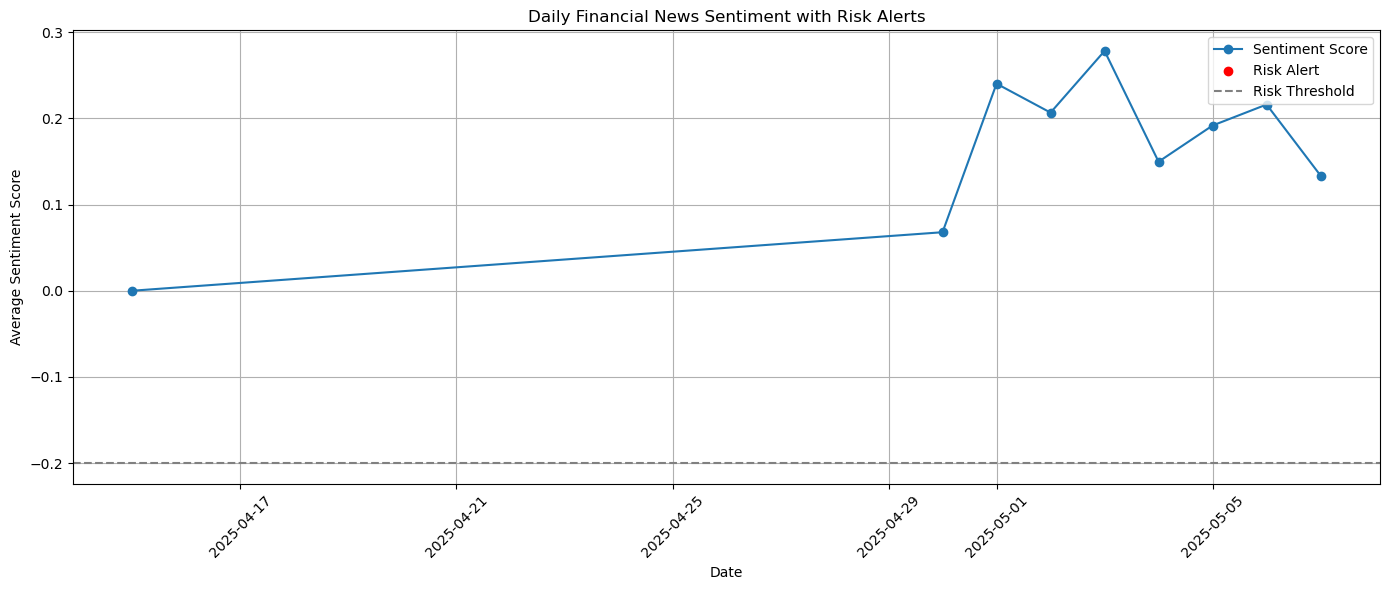

In [7]:
plt.figure(figsize=(14, 6))
plt.plot(daily_sentiment['date'], daily_sentiment['sentiment_score'], marker='o', label='Sentiment Score')

# Highlight risk alert days
risk_days = daily_sentiment[daily_sentiment['risk_alert']]
plt.scatter(risk_days['date'], risk_days['sentiment_score'], color='red', label='Risk Alert', zorder=5)

# Add threshold line
plt.axhline(y=risk_threshold, color='gray', linestyle='--', label='Risk Threshold')

plt.title('Daily Financial News Sentiment with Risk Alerts')
plt.xlabel('Date')
plt.ylabel('Average Sentiment Score')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [8]:
import seaborn as sns

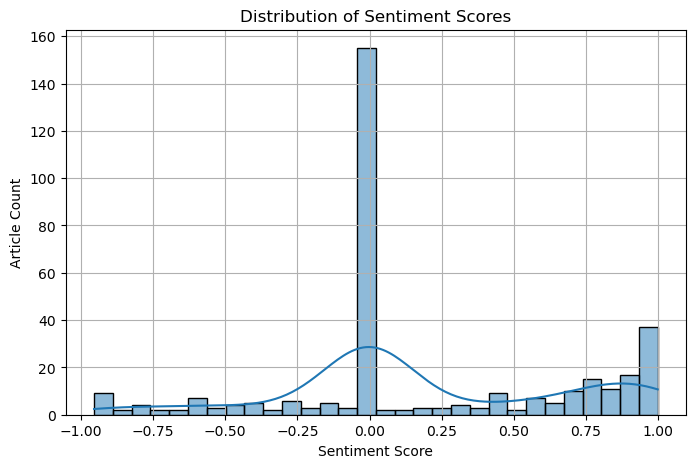

In [9]:
plt.figure(figsize=(8, 5))
sns.histplot(df_all['sentiment_score'], bins=30, kde=True)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Article Count')
plt.grid(True)
plt.show()


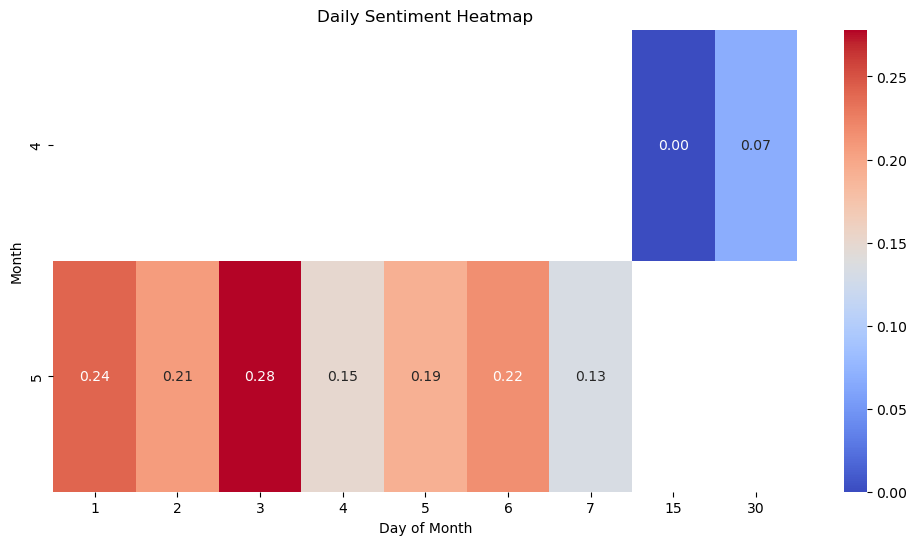

In [10]:
heatmap_data = daily_sentiment.copy()
heatmap_data['month'] = pd.to_datetime(heatmap_data['date']).dt.month
heatmap_data['day'] = pd.to_datetime(heatmap_data['date']).dt.day
pivot = heatmap_data.pivot_table(index='month', columns='day', values='sentiment_score')

plt.figure(figsize=(12, 6))
sns.heatmap(pivot, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Daily Sentiment Heatmap')
plt.xlabel('Day of Month')
plt.ylabel('Month')
plt.show()


In [11]:
# Top positive
print("Top Positive Headlines:")
print(df_all.sort_values(by='sentiment_score', ascending=False)[['publishedAt', 'description']].head(5))

# Top negative
print("\nTop Negative Headlines:")
print(df_all.sort_values(by='sentiment_score')[['publishedAt', 'description']].head(5))


Top Positive Headlines:
                  publishedAt  \
160 2025-05-05 09:54:30+00:00   
24  2025-05-01 00:36:46+00:00   
163 2025-05-03 11:33:11+00:00   
147 2025-05-01 17:29:38+00:00   
174 2025-05-01 22:09:23+00:00   

                                           description  
160  I've been digging into a few high-quality busi...  
24   The US and Kyiv have signed an agreement to sh...  
163  Hi all,\n\nI hope everyone is doing well. \n\n...  
147  I grew up in an upper middle class family. I a...  
174  A lot of people are asking about ETFs that are...  

Top Negative Headlines:
                  publishedAt  \
44  2025-05-01 15:51:20+00:00   
254 2025-04-30 14:12:43+00:00   
126 2025-05-04 04:27:01+00:00   
243 2025-05-02 12:32:38+00:00   
237 2025-05-01 23:26:23+00:00   

                                           description  
44   US manufacturing activity slid to a five-month...  
254  GDP/stocks down while yields go up is not the ...  
126  Just found out that my email was pa

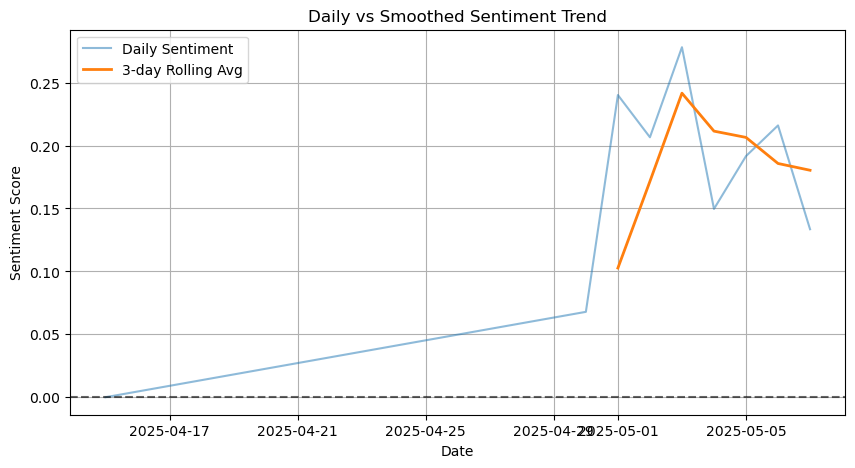

In [12]:
daily_sentiment['rolling_sentiment'] = daily_sentiment['sentiment_score'].rolling(window=3).mean()

plt.figure(figsize=(10, 5))
plt.plot(daily_sentiment['date'], daily_sentiment['sentiment_score'], label='Daily Sentiment', alpha=0.5)
plt.plot(daily_sentiment['date'], daily_sentiment['rolling_sentiment'], label='3-day Rolling Avg', linewidth=2)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.6)
plt.title('Daily vs Smoothed Sentiment Trend')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.legend()
plt.grid(True)
plt.show()


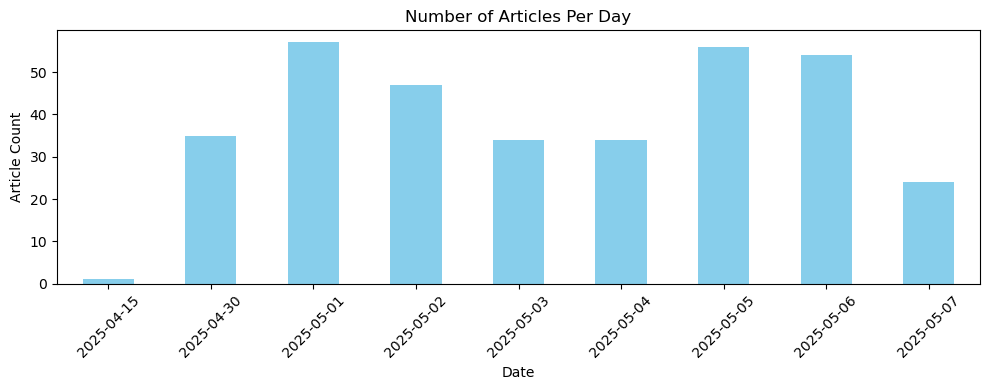

In [13]:
df_all['date'] = pd.to_datetime(df_all['publishedAt']).dt.date
article_count = df_all.groupby('date').size()

plt.figure(figsize=(10, 4))
article_count.plot(kind='bar', color='skyblue')
plt.title('Number of Articles Per Day')
plt.xlabel('Date')
plt.ylabel('Article Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [14]:
daily_sentiment['risk_alert'] = daily_sentiment['sentiment_score'] < -0.3


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Example features
daily_sentiment['article_count'] = df_all.groupby('date').size()
daily_sentiment['rolling_sentiment'] = daily_sentiment['sentiment_score'].rolling(3).mean().fillna(0)

X = daily_sentiment[['sentiment_score', 'rolling_sentiment', 'article_count']]
y = daily_sentiment['risk_alert'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



In [16]:
# Define a threshold for sentiment that triggers a risk alert
threshold = df_all['sentiment_score'].quantile(0.1)  # You can change this value

# Create the risk_alert column (1 = alert, 0 = no alert)
df_all['risk_alert'] = (df_all['sentiment_score'] <= threshold).astype(int)


In [17]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Assuming your DataFrame is called df and contains:
# features in X and target in y

# Step 1: Define features (X) and target (y)
X = df_all[['sentiment_score']]  # You can add more features here
y = df_all['risk_alert']         # Your target variable

# Step 2: Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Step 3: Initialize model
model = RandomForestClassifier(random_state=42)

# Step 4: Cross-validation loop
all_reports = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n📂 Fold {fold + 1}")
    print(classification_report(y_test, y_pred))
    all_reports.append(accuracy_score(y_test, y_pred))

# Step 5: Final average accuracy
print(f"\n✅ Average Accuracy across folds: {np.mean(all_reports):.2f}")



📂 Fold 1
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        62
           1       1.00      1.00      1.00         7

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69


📂 Fold 2
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        62
           1       1.00      1.00      1.00         7

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69


📂 Fold 3
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        61
           1       1.00      1.00      1.00         7

    accuracy                           1.00        68
   macro avg       1.00      1.00      1.00        68
weighted avg       1.00      1.00      1.00 

In [18]:
# Check the column names in  dataframe
print(df_all.columns)


Index(['title', 'url', 'publishedAt', 'description', 'source',
       'sentiment_score', 'date', 'risk_alert'],
      dtype='object')


In [19]:
import pandas as pd
import re




# Step 2: Combine 'title' and 'description' into a single text field
df_all['text'] = df_all['title'].fillna('') + ' ' + df_all['description'].fillna('')

# Step 3: Clean the combined text
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)         # Remove punctuation
    text = re.sub(r'\d+', '', text)          # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra spaces
    return text

df_all['clean_text'] = df_all['text'].apply(clean_text)

# Step 4: Feature Engineering
df_all['article_length'] = df_all['clean_text'].str.len()
df_all['word_count'] = df_all['clean_text'].str.split().apply(len)

# Step 5: Ensure date is in datetime format
df_all['date'] = pd.to_datetime(df_all['date'], errors='coerce')

# Step 6: Drop missing values in required columns
df_all = df_all.dropna(subset=['sentiment_score', 'clean_text', 'date'])

# Final preview
print(df_all[['date', 'sentiment_score', 'risk_alert', 'article_length', 'word_count']].head())


          date  sentiment_score  risk_alert  article_length  word_count
339 2025-04-15           0.0000           0              74          12
60  2025-04-30           0.0000           0              41           8
140 2025-04-30           0.9386           0            1321         246
104 2025-04-30           0.0000           0             787         107
88  2025-04-30           0.0000           0              76          11


In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import SMOTE



# ---------------------
# Feature Engineering
# ---------------------

# Ensure date is in datetime format
df_all['date'] = pd.to_datetime(df_all['date'], errors='coerce')

# Handle missing sentiment_score if needed
df_all = df_all.dropna(subset=['sentiment_score'])

# Add article_length and word_count features
df_all['article_length'] = df_all['clean_text'].str.len()
df_all['word_count'] = df_all['clean_text'].str.split().apply(len)

# ---------------------
# Risk Alert Labeling
# ---------------------

# Define threshold (e.g., bottom 10% sentiment scores)
threshold = df_all['sentiment_score'].quantile(0.1)

# Create binary risk alert
df_all['risk_alert'] = (df_all['sentiment_score'] <= threshold).astype(int)

# ---------------------
# Features and Target
# ---------------------

features = ['sentiment_score', 'article_length', 'word_count']
X = df_all[features]
y = df_all['risk_alert']

# ---------------------
# Apply SMOTE
# ---------------------
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# ---------------------
# Modeling with Stratified K-Fold
# ---------------------

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
clf = RandomForestClassifier(random_state=42)

for fold, (train_index, test_index) in enumerate(skf.split(X_res, y_res), 1):
    X_train, X_test = X_res.iloc[train_index], X_res.iloc[test_index]
    y_train, y_test = y_res.iloc[train_index], y_res.iloc[test_index]
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    print(f"\n--- Fold {fold} Classification Report ---")
    print(classification_report(y_test, y_pred))



--- Fold 1 Classification Report ---
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        62
           1       0.98      1.00      0.99        61

    accuracy                           0.99       123
   macro avg       0.99      0.99      0.99       123
weighted avg       0.99      0.99      0.99       123


--- Fold 2 Classification Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        62
           1       1.00      1.00      1.00        61

    accuracy                           1.00       123
   macro avg       1.00      1.00      1.00       123
weighted avg       1.00      1.00      1.00       123


--- Fold 3 Classification Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        61
           1       1.00      1.00      1.00        62

    accuracy                           1.00       123
   macro avg  

In [21]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# -------- Step 1: TF-IDF Vectorization --------
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, 
    min_df=2, 
    stop_words='english'
)

tfidf = tfidf_vectorizer.fit_transform(df_all['clean_text'])

# -------- Step 2: LDA Topic Modeling --------
lda_model = LatentDirichletAllocation(
    n_components=5,         # Number of topics
    max_iter=10, 
    learning_method='online', 
    random_state=42
)
lda_model.fit(tfidf)

# -------- Step 3: Display Top Words per Topic --------
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"\n🔹 Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

# Show top 10 words per topic
display_topics(lda_model, tfidf_vectorizer.get_feature_names_out(), 10)



🔹 Topic 1:
tomorrow like good market just trade stocks oil pltr money

🔹 Topic 2:
trump tariff rates fed tariffs com today https buy stocks

🔹 Topic 3:
owned falls new company trump sgov buffet gdp factory bond

🔹 Topic 4:
buffett just investing market stock berkshire reddit invest years like

🔹 Topic 5:
china trade tariffs deal war openai says trump ceo japan


In [22]:
from datetime import datetime

# Ensure 'date' column is in datetime format
df_all['date'] = pd.to_datetime(df_all['date'])

# Get the most recent date's data
latest_date = df_all['date'].max()
latest_data = df_all[df_all['date'] == latest_date]

# Check if there's a risk alert
if latest_data['risk_alert'].any():
    print(f"⚠️ ALERT: Risk detected on {latest_date.date()} based on sentiment analysis!")
else:
    print(f"✅ No risk detected on {latest_date.date()}.")


✅ No risk detected on 2025-05-07.


In [23]:
pip install plyer


Note: you may need to restart the kernel to use updated packages.


In [24]:
from plyer import notification

if latest_data['risk_alert'].any():
    notification.notify(
        title="Risk Alert: Financial Sentiment",
        message=f"⚠️ Negative sentiment detected on {latest_date.date()}!",
        timeout=10
    )


In [25]:
import smtplib
from email.mime.text import MIMEText

def send_email_alert(subject, body, to_email):
    from_email = "your_email@gmail.com"
    password = "your_app_password"

    msg = MIMEText(body)
    msg['Subject'] = subject
    msg['From'] = from_email
    msg['To'] = to_email

    with smtplib.SMTP_SSL('smtp.gmail.com', 465) as smtp:
        smtp.login(from_email, password)
        smtp.send_message(msg)

# Trigger
if latest_data['risk_alert'].any():
    send_email_alert(
        subject="Risk Alert: Financial Sentiment",
        body=f"Negative sentiment detected on {latest_date.date()}!",
        to_email="recipient@example.com"
    )


In [26]:
pip install streamlit


Note: you may need to restart the kernel to use updated packages.


In [29]:
df = pd.read_csv("data/all_financial_news.csv")
df.columns


Index(['title', 'url', 'publishedAt', 'description', 'source'], dtype='object')

In [30]:
df_all.columns

Index(['title', 'url', 'publishedAt', 'description', 'source',
       'sentiment_score', 'date', 'risk_alert', 'text', 'clean_text',
       'article_length', 'word_count'],
      dtype='object')

In [31]:

import os
if not os.path.exists('data'):
    os.makedirs('data')

# Save the DataFrame
df_all.to_csv('data/all_financial_news.csv', index=False)


In [34]:
df = pd.read_csv("data/all_financial_news.csv")
df.columns


Index(['title', 'url', 'publishedAt', 'description', 'source',
       'sentiment_score', 'date', 'risk_alert', 'text', 'clean_text',
       'article_length', 'word_count'],
      dtype='object')

In [33]:
import streamlit as st
import pandas as pd

# Load data
df_all = pd.read_csv("data/all_financial_news.csv")
df_all['date'] = pd.to_datetime(df_all['date'])

# Get latest day
latest_date = df_all['date'].max()
latest_data = df_all[df_all['date'] == latest_date]

st.title("📉 AI-Powered Financial Risk Alert")

st.subheader(f"Latest Date: {latest_date.date()}")
if latest_data['risk_alert'].any():
    st.error("⚠️ RISK ALERT: Negative sentiment detected!")
else:
    st.success("✅ No risk detected.")

# Show relevant articles
st.write("### Latest News Articles")
st.dataframe(latest_data[['title', 'sentiment_score', 'risk_alert']])


DeltaGenerator()